In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pdb_utils import *
from autoencoders import *
import pickle
import numpy as np
import random

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from functools import partial
import sys

from Bio import PDB
import numpy as np
import os
import cv2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import *

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [3]:
from keras.optimizers import Adam, Adadelta

Using TensorFlow backend.


In [4]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import regularizers

# Set random seed
np.random.seed(0)

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [8]:
def build_model(inp_dim,encoding_dim,sparse=False):
    # this is our input placeholder
    input_img = Input(shape=(inp_dim,))
    # "encoded" is the encoded representation of the input
    if sparse==True:
        encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)
    else:
        encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(inp_dim, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    optimizer = Adadelta(lr=0.001)
    autoencoder.compile(optimizer=optimizer, 
                    loss='mse',
                    metrics=['accuracy'])
    autoencoder.summary()
    return encoder,decoder,autoencoder

In [9]:
filter_size=64
resize_strategy = "strategy1"
batch_size = 100
num_iters = 100
input_size=2016

def top5score(index_dict,neighbors,testY):
    score = 0
    for i,nb in enumerate(neighbors):
        y = testY[i]
        for n in nb:
            if index_dict[n]==y:
                score+=1
                break
    return(score/float(len(neighbors)))

def createVector(pdb,encoding_size):
    parser = PDB.PDBParser()
    pdb_path = "SCOP40mini/"+pdb+".ent"
    structure = parser.get_structure(pdb, pdb_path)[0]
    dm = createDistanceMatrix(structure,resize_strategy,resize_to=(encoding_size,encoding_size),sample_size=None)
    protein_matrix = RemoveSymmetry(dm)
    return protein_matrix

In [14]:
with open("Minidatabase_all_tasks.pkl","r") as f:
    all_tasks = pickle.load(f)

In [29]:
overall_train_score = 0
overall_test_score = 0
for task in list(all_tasks.keys()):
    print(task+"\n")
    X_train,y_train=[],[]
    X_test,y_test=[],[]
    for pdb in all_tasks[task]["+train"]:
        protein_matrix = createVector(pdb,880)
        X_train.append(protein_matrix)
        y_train.append(1)
    for pdb in all_tasks[task]["-train"]:
        protein_matrix = createVector(pdb,880)
        X_train.append(protein_matrix)
        y_train.append(0)
    for pdb in all_tasks[task]["+test"]:
        protein_matrix = createVector(pdb,880)
        X_test.append(protein_matrix)
        y_test.append(1)
    for pdb in all_tasks[task]["-test"]:
        protein_matrix = createVector(pdb,880)
        X_test.append(protein_matrix)
        y_test.append(0)


    pca = PCA(n_components=0.99,svd_solver='full')
    pca.fit(X_train)
    print("n_components: "+str(pca.n_components_)+"\n")

    X_train_ = pca.transform(X_train)
    X_test_ = pca.transform(X_test)

    rf = RandomForestClassifier()
    rf.fit(X_train_,y_train)
    test_pred = rf.predict(X_test_)
    train_pred = rf.predict(X_train_)

    test_score = roc_auc_score(y_test, test_pred)
    train_score = roc_auc_score(y_train, train_pred)
    print("Train accuracy: "+str(train_score)+"\n")
    print("Test accuracy: "+str(test_score)+"\n")
    overall_train_score+=train_score
    overall_test_score+=test_score

c.37.1._c.37.1.6.

n_components: 421

Train accuracy: 0.9583333333333333

Test accuracy: 0.46790540540540543

b.40.4._b.40.4.5.

n_components: 387

Train accuracy: 0.9148936170212766

Test accuracy: 0.4984472049689441

c.37.1._c.37.1.9.

n_components: 422

Train accuracy: 0.9578313253012047

Test accuracy: 0.6855694980694981

c.37.1._c.37.1.5.

n_components: 420

Train accuracy: 0.9668674698795181

Test accuracy: 0.6948600386100386

c.37.1._c.37.1.8.

n_components: 409

Train accuracy: 0.9612676056338028

Test accuracy: 0.48057432432432434

c.2.1._c.2.1.7.

n_components: 411

Train accuracy: 0.9738805970149254

Test accuracy: 0.48509933774834435

a.4.5._a.4.5.28.

n_components: 392

Train accuracy: 0.9728260869565217

Test accuracy: 0.5

c.3.1._c.3.1.4.

n_components: 391

Train accuracy: 0.9215686274509804

Test accuracy: 0.49923195084485406

c.37.1._c.37.1.10.

n_components: 418

Train accuracy: 0.9316770186335404

Test accuracy: 0.47466216216216217

c.37.1._c.37.1.12.

n_components:

In [12]:
overall_train_score/55

0.9925031083561171

In [13]:
overall_test_score/55

0.9753772650888503

In [15]:
from sklearn.metrics import roc_auc_score

In [ ]:
overall_train_score = 0
overall_test_score = 0
for task in list(all_tasks.keys())[-1:]:
    print(task+"\n")
    X_train,y_train=[],[]
    X_test,y_test=[],[]
    for pdb in all_tasks[task]["+train"]:
        protein_matrix = createVector(pdb,64)
        X_train.append(protein_matrix)
        y_train.append(1)
    for pdb in all_tasks[task]["-train"]:
        protein_matrix = createVector(pdb,64)
        X_train.append(protein_matrix)
        y_train.append(0)
    for pdb in all_tasks[task]["+test"]:
        protein_matrix = createVector(pdb,64)
        X_test.append(protein_matrix)
        y_test.append(1)
    for pdb in all_tasks[task]["-test"]:
        protein_matrix = createVector(pdb,64)
        X_test.append(protein_matrix)
        y_test.append(0)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    inp_dim = X_train.shape[1]
    enc_dim = 100
    encoder,decoder,autoencoder = build_model(inp_dim,enc_dim)
    # Set callback functions to early stop training and save the best model so far
    callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    x = autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=100,
                callbacks=callbacks, # Early stopping
                shuffle=True,
                validation_split=0.4)
    
    # LOSS GRAPH
    loss = x.history['val_loss']
    fig, ax = plt.subplots()
    ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)
    plt.savefig(task+".png")
    
    X_train_ = encoder.predict(X_train)
    X_test_ = encoder.predict(X_test)

    rf = RandomForestClassifier(max_depth=10)
    rf.fit(X_train_,y_train)
    
    test_pred = rf.predict(X_test_)
    train_pred = rf.predict(X_train_)

    test_score = roc_auc_score(y_test, test_pred)
    train_score = roc_auc_score(y_train, train_pred)
    print("Train accuracy: "+str(train_score)+"\n")
    print("Test accuracy: "+str(test_score)+"\n")
    overall_train_score+=train_score
    overall_test_score+=test_score

In [12]:
overall_train_score/55.

0.011721420871618501

In [13]:
overall_test_score/55.

0.009034443817052512

In [14]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(y_test, test_pred,target_names=["positive","negative"]))

              precision    recall  f1-score   support

    positive       0.98      1.00      0.99       644
    negative       0.00      0.00      0.00        14

   micro avg       0.98      0.98      0.98       658
   macro avg       0.49      0.50      0.49       658
weighted avg       0.96      0.98      0.97       658



In [21]:
accuracy_score(y_test,test_pred)

0.9787234042553191

In [177]:
with open("X_train_all.pkl","w") as f:
    pickle.dump(X_train_all,f,protocol=2)

In [ ]:
X_train_all=[]
c=1
for task in list(all_tasks.keys()):
    print(c)
    c+=1
    for pdb in all_tasks[task]["+train"]:
        protein_matrix = createVector(pdb,64)
        X_train_all.append(protein_matrix)
    for pdb in all_tasks[task]["-train"]:
        protein_matrix = createVector(pdb,64)
        X_train_all.append(protein_matrix)

X_train_all = np.array(X_train_all)
inp_dim = X_train_all.shape[1]
enc_dim = 100
    
encoder,decoder,autoencoder = build_model(inp_dim,enc_dim)
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='autoencoder.h5', monitor='val_loss', save_best_only=True)]

x = autoencoder.fit(X_train_all, X_train_all,
                epochs=100,
                batch_size=50,
                callbacks=callbacks, # Early stopping
                shuffle=True,
                validation_split=0.2)
    
# LOSS GRAPH
loss = x.history['val_loss']
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)

encoder.save("encoder.h5")    

In [28]:
overall_train_score = 0
overall_test_score = 0
for task in list(all_tasks.keys())[:2]:
    print(task+"\n")
    X_train,y_train=[],[]
    X_test,y_test=[],[]
    for pdb in all_tasks[task]["+train"]:
        protein_matrix = createVector(pdb,64)
        X_train.append(protein_matrix)
        y_train.append(1)
    for pdb in all_tasks[task]["-train"]:
        protein_matrix = createVector(pdb,64)
        X_train.append(protein_matrix)
        y_train.append(0)
    for pdb in all_tasks[task]["+test"]:
        protein_matrix = createVector(pdb,64)
        X_test.append(protein_matrix)
        y_test.append(1)
    for pdb in all_tasks[task]["-test"]:
        protein_matrix = createVector(pdb,64)
        X_test.append(protein_matrix)
        y_test.append(0)
    
    X_train_ = encoder.predict(np.array(X_train))
    X_test_ = encoder.predict(np.array(X_test))

    rf = RandomForestClassifier(n_estimators=50,max_depth=20)
    rf.fit(X_train_,y_train)
    test_pred = rf.predict(X_test_)
    train_pred = rf.predict(X_train_)

    test_score = roc_auc_score(y_test, test_pred)
    train_score = roc_auc_score(y_train, train_pred)
    print("Train auc score: "+str(train_score)+"\n")
    print("Test auc score: "+str(test_score)+"\n")
    overall_train_score+=train_score
    overall_test_score+=test_score

c.37.1._c.37.1.6.

Train auc score: 1.0

Test auc score: 0.4847972972972973

b.40.4._b.40.4.5.

Train auc score: 1.0

Test auc score: 0.5



In [11]:
from keras.models import load_model

In [12]:
model = load_model("encoder.h5")

In [175]:
X_train=[]
pdbs = []
for task in list(all_tasks.keys()):
    for pdb in all_tasks[task]["+train"]:
        if pdb not in pdbs:
            protein_matrix = createVector(pdb,64)
            X_train.append(protein_matrix)
            pdbs.append(pdb)
    for pdb in all_tasks[task]["-train"]:
        if pdb not in pdbs:
            protein_matrix = createVector(pdb,64)
            X_train.append(protein_matrix)
            pdbs.append(pdb)

X_train_all = np.array(X_train)
print(X_train_all.shape)

pca = PCA(n_components=0.90,svd_solver='full')
pca.fit(X_train_all)
print("n_components: "+str(pca.n_components_)+"\n")

(1300, 2016)
n_components: 95



In [ ]:
# Autoencoder visualization
inp_dim = X_train_all.shape[1]
enc_dim = 500
print(inp_dim)
    
encoder,decoder,autoencoder = build_model(inp_dim,enc_dim)
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='autoencoder.h5', monitor='val_loss', save_best_only=True)]

x = autoencoder.fit(X_train_all, X_train_all,
                epochs=1000,
                batch_size=1000,
                callbacks=callbacks, # Early stopping
                shuffle=True,
                validation_split=0.2)
    
# LOSS GRAPH
loss = x.history['val_loss']
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)

In [116]:
pca2 = PCA(n_components=2)
pca2.fit(X_train_all)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [156]:
with open("Data_64x64_c.37.1._c.37.1.6..pkl","r") as f:
    X_train,y_train,X_test,y_test = pickle.load(f)

In [117]:
negatives_x=[]
negatives_y = []
positives_x = []
positives_y=[]
for x,label in zip(X_train,y_train):
    twodims = pca.transform(np.array([x]))[0]
    x,y = twodims[0],twodims[1]
    if label==0: # negative
        negatives_x.append(x)
        negatives_y.append(y)
    elif label==1: #postive
        positives_x.append(x)
        positives_y.append(y)

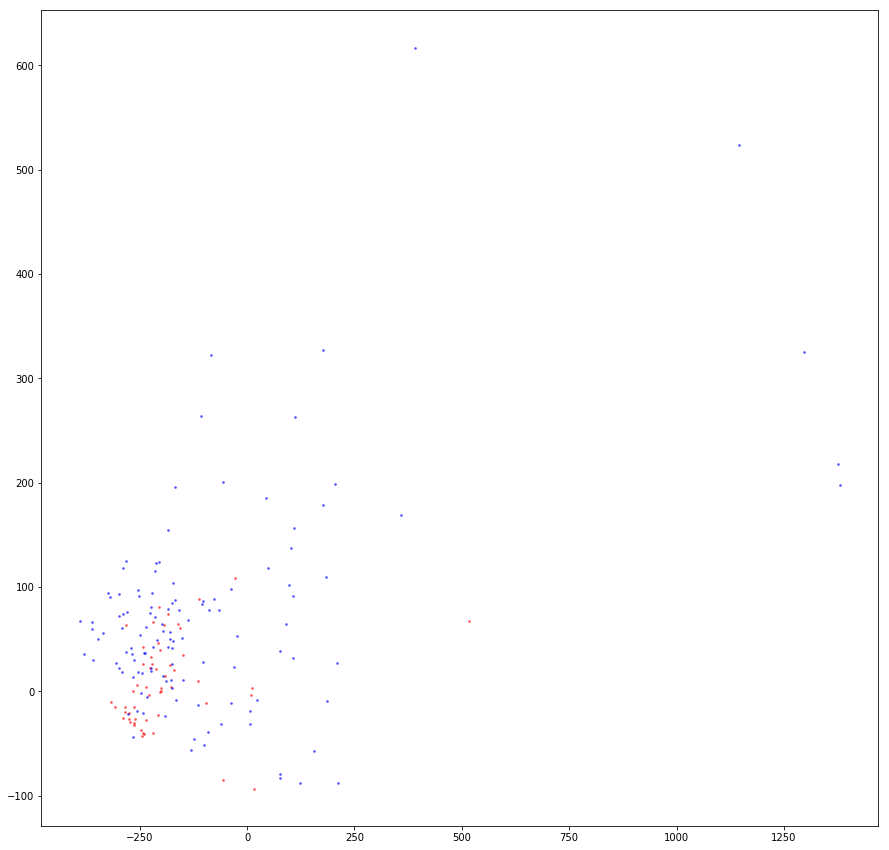

In [118]:
plt.figure(figsize=(15,15))
plt.scatter(positives_x,positives_y,color="red",alpha=0.5,s=3)
plt.scatter(negatives_x,negatives_y,color="blue",alpha=0.5,s=3)

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [154]:
pca = PCA(n_components=0.90)
pca.fit(X_train_all)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [167]:
print(pca.n_components_)

88


In [168]:
X_train_ = pca.transform(np.array(X_train))
X_test_ = pca.transform(np.array(X_test))
y_train_ = np.array(y_train)
y_test_ = np.array(y_test)

In [169]:
X_test_.shape

(597, 88)

In [174]:
# Number of trees in random forest
n_estimators = range(100,500,100)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = range(50,550,50)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state=0)
clf = GridSearchCV(rf, parameters, cv=10,verbose=1)
clf.fit(X_train_,y_train_)

test_pred = clf.predict(X_test_)
train_pred = clf.predict(X_train_)

test_score = roc_auc_score(y_test_, test_pred)
train_score = roc_auc_score(y_train_, train_pred)

Fitting 10 folds for each of 1440 candidates, totalling 14400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
print(train_score)
print(test_score)

In [19]:
overall_train_score = 0
overall_test_score = 0
for task in list(all_tasks.keys())[:1]:
    print(task+"\n")
    X_train,y_train=[],[]
    X_test,y_test=[],[]
    for pdb in all_tasks[task]["+train"]:
        protein_matrix = createVector(pdb,64)
        X_train.append(protein_matrix)
        y_train.append(1)
    for pdb in all_tasks[task]["-train"]:
        protein_matrix = createVector(pdb,64)
        X_train.append(protein_matrix)
        y_train.append(0)
    for pdb in all_tasks[task]["+test"]:
        protein_matrix = createVector(pdb,64)
        X_test.append(protein_matrix)
        y_test.append(1)
    for pdb in all_tasks[task]["-test"]:
        protein_matrix = createVector(pdb,64)
        X_test.append(protein_matrix)
        y_test.append(0)

    X_train_ = pca.transform(X_train)
    X_test_ = pca.transform(X_test)

    rf = RandomForestClassifier(n_estimators=50,max_depth=20)
    rf.fit(X_train_,y_train)
    test_pred = rf.predict(X_test_)
    train_pred = rf.predict(X_train_)

    test_score = roc_auc_score(y_test, test_pred)
    train_score = roc_auc_score(y_train, train_pred)
    print("Train auc score: "+str(train_score)+"\n")
    print("Test auc score: "+str(test_score)+"\n")
    overall_train_score+=train_score
    overall_test_score+=test_score

c.37.1._c.37.1.6.

Train accuracy: 1.0

Test accuracy: 0.49408783783783783

b.40.4._b.40.4.5.

Train accuracy: 1.0

Test accuracy: 0.5

c.37.1._c.37.1.9.

Train accuracy: 1.0

Test accuracy: 0.5663610038610039

c.37.1._c.37.1.5.

Train accuracy: 1.0

Test accuracy: 0.49324324324324326

c.37.1._c.37.1.8.

Train accuracy: 1.0

Test accuracy: 0.49408783783783783

c.2.1._c.2.1.7.

Train accuracy: 1.0

Test accuracy: 0.5

a.4.5._a.4.5.28.

Train accuracy: 1.0

Test accuracy: 0.49920382165605093

c.3.1._c.3.1.4.

Train accuracy: 1.0

Test accuracy: 0.49846390168970817

c.37.1._c.37.1.10.

Train accuracy: 1.0

Test accuracy: 0.4983108108108108

c.37.1._c.37.1.12.

Train accuracy: 1.0

Test accuracy: 0.49408783783783783

b.40.4._b.40.4.3.

Train accuracy: 1.0

Test accuracy: 0.5

b.40.4._b.40.4.4.

Train accuracy: 0.9924242424242424

Test accuracy: 0.5

c.37.1._c.37.1.20.

Train accuracy: 1.0

Test accuracy: 0.49239864864864863

c.47.1._c.47.1.5.

Train accuracy: 1.0

Test accuracy: 0.5

c.37.

In [20]:
overall_test_score/55.

0.5160441097711865

In [21]:
overall_train_score/55.

0.9992221616665599